In [1]:
import pandas as pd
import numpy as py
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import train_test_split

# Needed for API key
from dotenv import load_dotenv
import os
import requests

In [2]:
stock = 'GME'
load_dotenv()
key = os.getenv('key')

In [3]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={key}'
r = requests.get(url)
data = r.json()

In [4]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GME',
 '3. Last Refreshed': '2025-03-26',
 '4. Output Size': 'Compact',
 '5. Time Zone': 'US/Eastern'}

In [5]:
gme_data = data['Time Series (Daily)']

In [6]:
df = pd.DataFrame.from_dict(gme_data, orient = 'index')
df.index = pd.to_datetime(df.index)
df = df.astype(float)
df = df.sort_index()
df

,1. open,2. high,3. low,4. close,5. volume
2024-10-30,23.40,24.5400,22.7500,23.28,12383567.0
2024-10-31,22.83,23.0306,22.0500,22.18,5594540.0
2024-11-01,22.40,23.0500,22.0800,22.41,4744478.0
2024-11-04,22.20,22.6500,21.8823,22.33,4300154.0
2024-11-05,22.32,23.2000,22.2734,22.99,5858361.0
...,...,...,...,...,...
2025-03-20,23.65,24.1200,23.5100,23.51,1998220.0
2025-03-21,23.75,24.8100,23.6500,24.75,6893871.0
2025-03-24,25.35,25.8300,25.1500,25.61,5036047.0
2025-03-25,25.70,25.7700,24.9901,25.40,10106783.0


In [7]:
# get rid of 1s and 2s in front of column names
df.columns = df.columns.str.replace(r"^\d+\.\s*", "", regex=True)

In [8]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [9]:
df.shape

(100, 5)

In [10]:
df.groupby(df.index.date).size()

2024-10-30    1
2024-10-31    1
2024-11-01    1
2024-11-04    1
2024-11-05    1
             ..
2025-03-20    1
2025-03-21    1
2025-03-24    1
2025-03-25    1
2025-03-26    1
Length: 100, dtype: int64

In [11]:
start_date = df.index.min().date().strftime('%Y%m%d')
end_date = df.index.max().date().strftime('%Y%m%d')

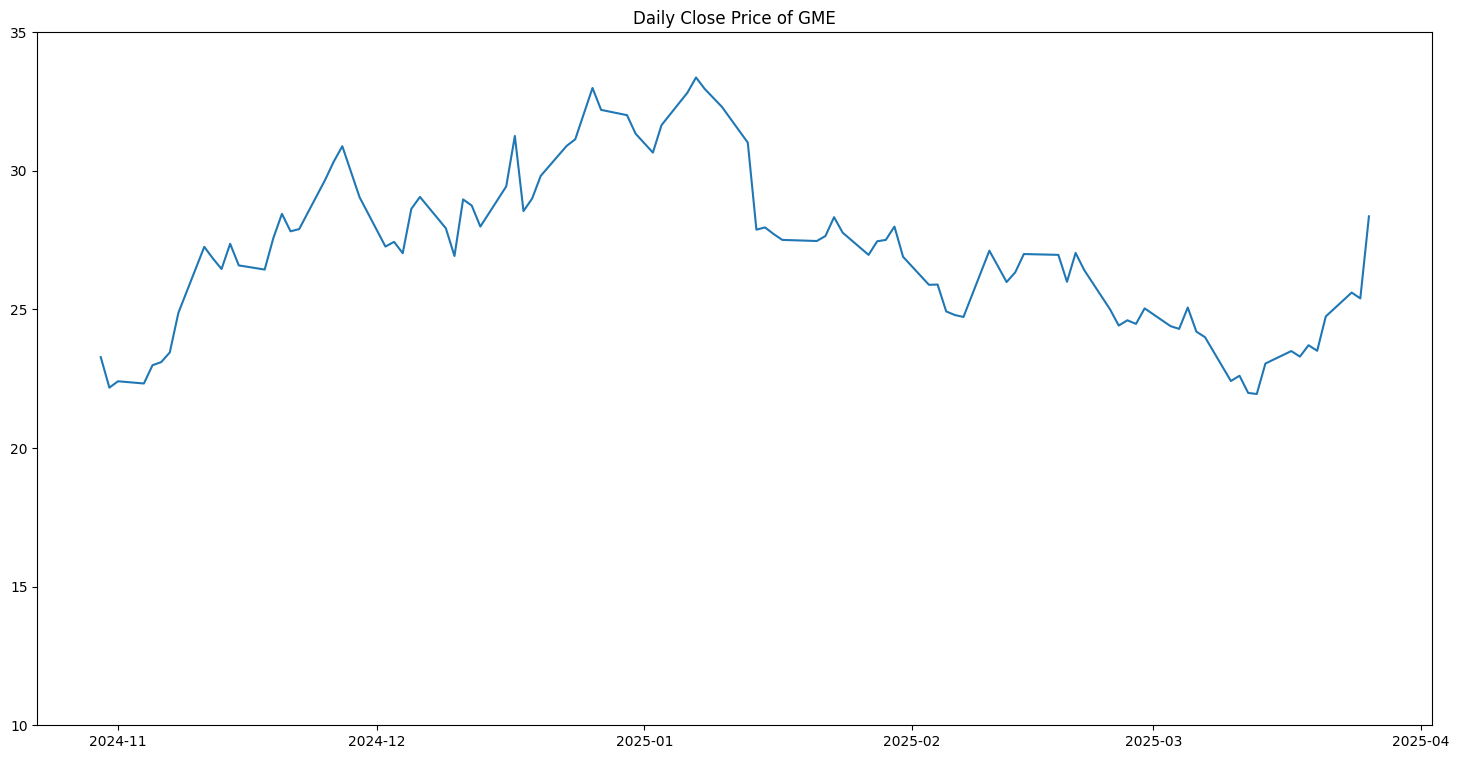

In [12]:
plt.figure(figsize = (18,9))
plt.plot(df['close'])
plt.title('Daily Close Price of GME')
plt.yticks(range(10,40,5));

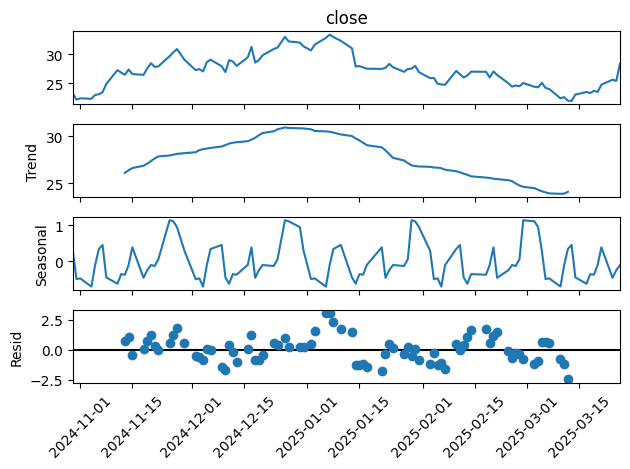

In [13]:
decomp = seasonal_decompose(df['close'],model='additive', period = 21)
fig = decomp.plot()

# Rotate only the Resid x-axis 45 degrees so it is legible
resid_ax = fig.axes[-1]
for label in resid_ax.get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

# Get in News

In [14]:
news_url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={stock}&time_from={start_date}T0000&time_to={end_date}T0000&apikey={key}'
r = requests.get(news_url)
data = r.json()

In [15]:
feed_items = data['feed']

In [16]:
feed_items

[{'title': 'GameStop hints at future Bitcoin purchases following board approval',
  'url': 'https://cointelegraph.com/news/gamestop-future-bitcoin-purchases-board-approval',
  'time_published': '20250325T210529',
  'authors': ['Sam Bourgi'],
  'summary': 'GameStop Corporation ( GME ) , the video game retailer turned memecoin stock, is reportedly moving to invest in Bitcoin after its board unanimously approved a plan to acquire digital assets. According to a March 25 CNBC report, the company announced that it would use a portion of its corporate ...',
  'banner_image': 'https://s3.cointelegraph.com/uploads/2025-03/0195cf19-3a51-79ec-8341-db33c042b940',
  'source': 'Cointelegraph',
  'category_within_source': 'n/a',
  'source_domain': 'cointelegraph.com',
  'topics': [{'topic': 'Retail & Wholesale', 'relevance_score': '1.0'},
   {'topic': 'Financial Markets', 'relevance_score': '0.266143'},
   {'topic': 'Earnings', 'relevance_score': '0.310843'},
   {'topic': 'Blockchain', 'relevance_sco

In [17]:
flat_data = []

for article in feed_items:
    base = {
        'title': article.get('title'),
        'time_published': article.get('time_published'),
        'authors': ", ".join(article.get('authors', [])),
        'summary': article.get('summary'),
        'source': article.get('source'),
        'overall_sentiment_score': article.get('overall_sentiment_score'),
        'overall_sentiment_label': article.get('overall_sentiment_label'),
    }

    # Topics as comma-separated string
    topics = article.get('topics', [])
    topic_names = [t['topic'] for t in topics]
    base['topics'] = ", ".join(topic_names)

    # Ticker sentiment - multiple tickers possible, so one row per ticker
    for ticker_info in article.get('ticker_sentiment', []):
        if ticker_info.get('ticker') == stock:
            base['ticker'] = ticker_info.get('ticker')
            base['ticker_relevance_score'] = ticker_info.get('relevance_score')
            base['ticker_sentiment_score'] = ticker_info.get('ticker_sentiment_score')
            base['ticker_sentiment_label'] = ticker_info.get('ticker_sentiment_label')
            flat_data.append(base)
            break

news = pd.DataFrame(flat_data)

In [18]:
news

,title,time_published,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
0,GameStop hints at future Bitcoin purchases fol...,20250325T210529,Sam Bourgi,"GameStop Corporation ( GME ) , the video game ...",Cointelegraph,0.091772,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.627119,0.248673,Somewhat-Bullish
1,GameStop Adds Bitcoin as 'Treasury Reserve Asset',20250325T203532,"Stacy Elliott, André Beganski","GME ended the day having lost 0.82%, but has g...",Decrypt.co,0.111974,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.674691,0.157681,Somewhat-Bullish
2,"GameStop to invest corporate cash in bitcoin, ...",20250325T203026,,Video game retailer GameStop announced Tuesday...,CNBC,0.147312,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.490323,0.16713,Somewhat-Bullish
3,"Bitcoin, Ethereum, XRP, Trade Flat While Dogec...",20250325T201906,Khyathi Dalal,Global cryptocurrency market capitalization re...,Benzinga,0.135304,Neutral,"Retail & Wholesale, Blockchain, Financial Markets",GME,0.077343,0.097217,Neutral
4,GameStop Rumored to Buy Bitcoin After CEO Pose...,20250325T155020,André Beganski,GameStop had amassed $4.6 billion in cash and ...,Decrypt.co,0.091958,Neutral,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.630923,0.168243,Somewhat-Bullish
5,GameStop Q4 Earnings Loom: Will Bullish Techni...,20250325T154404,Surbhi Jain,"GameStop stock is in a strong bullish trend, t...",Benzinga,0.114124,Neutral,"Earnings, Retail & Wholesale, Financial Markets",GME,0.584328,0.374489,Bullish
6,US Stocks Likely To Open Lower After 2-Day Adv...,20250325T095344,Rishabh Mishra,"U.S. stock futures declined on Tuesday, after ...",Benzinga,0.053316,Neutral,"Technology, Finance, Blockchain, Economy - Mon...",GME,0.071892,0.078445,Neutral
7,"Core & Main, KB Home And 3 Stocks To Watch Hea...",20250325T062703,Avi Kapoor,With U.S. stock futures trading lower this mor...,Benzinga,0.240299,Somewhat-Bullish,"Technology, Blockchain, Retail & Wholesale, Fi...",GME,0.405651,0.303305,Somewhat-Bullish
8,Dow Jumps Nearly 600 Points As Recession Fears...,20250325T062439,Avi Kapoor,The CNN Money Fear and Greed index showed furt...,Benzinga,0.041575,Neutral,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.178459,0.0,Neutral
9,GameStop Q4 Earnings Preview: Will Video Game ...,20250324T220243,Chris Katje,GameStop hintS at a potential Bitcoin investme...,Benzinga,0.147346,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.174587,0.037639,Neutral


In [19]:
news.isnull().sum()

title                      0
time_published             0
authors                    0
summary                    0
source                     0
overall_sentiment_score    0
overall_sentiment_label    0
topics                     0
ticker                     0
ticker_relevance_score     0
ticker_sentiment_score     0
ticker_sentiment_label     0
dtype: int64

In [20]:
news.shape

(50, 12)

In [21]:
news['authors'].unique()

array(['Sam Bourgi', 'Stacy Elliott, André Beganski', '', 'Khyathi Dalal',
       'André Beganski', 'Surbhi Jain', 'Rishabh Mishra', 'Avi Kapoor',
       'Chris Katje', 'Stephen Katte', 'Zacks Equity Research',
       'Akanksha Bakshi', 'Namrata Sen', 'Dylan Berman',
       'Brayden Lindrea', 'Ananya Gairola', 'Benzinga Insights',
       'Kaustubh Bagalkote', 'Shivani Kumaresan', 'James Rogers',
       'Ryan S. Gladwin', 'Marcel Pechman', 'Aniket Verma',
       'Sebastian Sinclair', 'Motley Fool Staff', 'Adam Eckert',
       'Mat Di Salvo', 'Eric Volkman', 'Sanghamitra Saha',
       'Shivdeep Dhaliwal'], dtype=object)

In [22]:
news['time_published'] = news['time_published'].str[:8]
news['time_published'] = pd.to_datetime(news['time_published'], format = '%Y%m%d')
news = news.set_index('time_published')

In [23]:
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-03-25,GameStop hints at future Bitcoin purchases fol...,Sam Bourgi,"GameStop Corporation ( GME ) , the video game ...",Cointelegraph,0.091772,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.627119,0.248673,Somewhat-Bullish
2025-03-25,GameStop Adds Bitcoin as 'Treasury Reserve Asset',"Stacy Elliott, André Beganski","GME ended the day having lost 0.82%, but has g...",Decrypt.co,0.111974,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.674691,0.157681,Somewhat-Bullish
2025-03-25,"GameStop to invest corporate cash in bitcoin, ...",,Video game retailer GameStop announced Tuesday...,CNBC,0.147312,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.490323,0.16713,Somewhat-Bullish
2025-03-25,"Bitcoin, Ethereum, XRP, Trade Flat While Dogec...",Khyathi Dalal,Global cryptocurrency market capitalization re...,Benzinga,0.135304,Neutral,"Retail & Wholesale, Blockchain, Financial Markets",GME,0.077343,0.097217,Neutral
2025-03-25,GameStop Rumored to Buy Bitcoin After CEO Pose...,André Beganski,GameStop had amassed $4.6 billion in cash and ...,Decrypt.co,0.091958,Neutral,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.630923,0.168243,Somewhat-Bullish
2025-03-25,GameStop Q4 Earnings Loom: Will Bullish Techni...,Surbhi Jain,"GameStop stock is in a strong bullish trend, t...",Benzinga,0.114124,Neutral,"Earnings, Retail & Wholesale, Financial Markets",GME,0.584328,0.374489,Bullish
2025-03-25,US Stocks Likely To Open Lower After 2-Day Adv...,Rishabh Mishra,"U.S. stock futures declined on Tuesday, after ...",Benzinga,0.053316,Neutral,"Technology, Finance, Blockchain, Economy - Mon...",GME,0.071892,0.078445,Neutral
2025-03-25,"Core & Main, KB Home And 3 Stocks To Watch Hea...",Avi Kapoor,With U.S. stock futures trading lower this mor...,Benzinga,0.240299,Somewhat-Bullish,"Technology, Blockchain, Retail & Wholesale, Fi...",GME,0.405651,0.303305,Somewhat-Bullish
2025-03-25,Dow Jumps Nearly 600 Points As Recession Fears...,Avi Kapoor,The CNN Money Fear and Greed index showed furt...,Benzinga,0.041575,Neutral,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.178459,0.0,Neutral


In [25]:
news.groupby(news.index.date).size()

2025-02-14    5
2025-02-15    2
2025-02-16    2
2025-02-17    1
2025-02-18    2
2025-02-19    2
2025-02-20    1
2025-02-26    3
2025-02-27    2
2025-02-28    1
2025-03-03    1
2025-03-04    5
2025-03-05    1
2025-03-07    2
2025-03-10    3
2025-03-11    2
2025-03-13    1
2025-03-14    2
2025-03-17    1
2025-03-18    1
2025-03-24    1
2025-03-25    9
dtype: int64

In [26]:
news[news['authors'] == '']

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-03-25,"GameStop to invest corporate cash in bitcoin, ...",,Video game retailer GameStop announced Tuesday...,CNBC,0.147312,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.490323,0.16713,Somewhat-Bullish
2025-03-04,Starbucks poaches Nordstrom CFO as executive s...,,"Nordstrom CFO Cathy Smith will join Starbucks,...",CNBC,0.155025,Somewhat-Bullish,"Retail & Wholesale, Technology, Manufacturing",GME,0.145145,0.078246,Neutral
2025-02-20,GameStop CEO Ryan Cohen hikes his personal sta...,,Cohen's sizable stake in Alibaba is a bullish ...,CNBC,0.172461,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Finance...",GME,0.423251,0.268642,Somewhat-Bullish
2025-02-19,Trump enthusiasm matches GameStop mania as sma...,,The share of retail investors trading the U.S....,CNBC,0.072246,Neutral,"Retail & Wholesale, Finance, Financial Markets",GME,0.140896,-0.089744,Neutral


In [27]:
news.loc[news['authors'] == '', 'authors'] = 'Unknown Author'
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-03-25,GameStop hints at future Bitcoin purchases fol...,Sam Bourgi,"GameStop Corporation ( GME ) , the video game ...",Cointelegraph,0.091772,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.627119,0.248673,Somewhat-Bullish
2025-03-25,GameStop Adds Bitcoin as 'Treasury Reserve Asset',"Stacy Elliott, André Beganski","GME ended the day having lost 0.82%, but has g...",Decrypt.co,0.111974,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.674691,0.157681,Somewhat-Bullish
2025-03-25,"GameStop to invest corporate cash in bitcoin, ...",Unknown Author,Video game retailer GameStop announced Tuesday...,CNBC,0.147312,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.490323,0.16713,Somewhat-Bullish
2025-03-25,"Bitcoin, Ethereum, XRP, Trade Flat While Dogec...",Khyathi Dalal,Global cryptocurrency market capitalization re...,Benzinga,0.135304,Neutral,"Retail & Wholesale, Blockchain, Financial Markets",GME,0.077343,0.097217,Neutral
2025-03-25,GameStop Rumored to Buy Bitcoin After CEO Pose...,André Beganski,GameStop had amassed $4.6 billion in cash and ...,Decrypt.co,0.091958,Neutral,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.630923,0.168243,Somewhat-Bullish
2025-03-25,GameStop Q4 Earnings Loom: Will Bullish Techni...,Surbhi Jain,"GameStop stock is in a strong bullish trend, t...",Benzinga,0.114124,Neutral,"Earnings, Retail & Wholesale, Financial Markets",GME,0.584328,0.374489,Bullish
2025-03-25,US Stocks Likely To Open Lower After 2-Day Adv...,Rishabh Mishra,"U.S. stock futures declined on Tuesday, after ...",Benzinga,0.053316,Neutral,"Technology, Finance, Blockchain, Economy - Mon...",GME,0.071892,0.078445,Neutral
2025-03-25,"Core & Main, KB Home And 3 Stocks To Watch Hea...",Avi Kapoor,With U.S. stock futures trading lower this mor...,Benzinga,0.240299,Somewhat-Bullish,"Technology, Blockchain, Retail & Wholesale, Fi...",GME,0.405651,0.303305,Somewhat-Bullish
2025-03-25,Dow Jumps Nearly 600 Points As Recession Fears...,Avi Kapoor,The CNN Money Fear and Greed index showed furt...,Benzinga,0.041575,Neutral,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.178459,0.0,Neutral


In [28]:
news['overall_sentiment_label'].unique()

array(['Neutral', 'Somewhat-Bullish', 'Bullish'], dtype=object)

In [29]:
news['ticker_sentiment_label'].unique()

array(['Somewhat-Bullish', 'Neutral', 'Bullish', 'Somewhat-Bearish',
       'Bearish'], dtype=object)

In [30]:
news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})
news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})

C:\Users\graha\AppData\Local\Temp\ipykernel_1540\3453675565.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
C:\Users\graha\AppData\Local\Temp\ipykernel_1540\3453675565.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({


# Merge both DataFrames

In [31]:
merged_df = df.merge(news,how = 'left',left_index = True, right_index = True)
merged_df = merged_df.fillna(0)
merged_df

,open,high,low,close,volume,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2024-10-30,23.40,24.5400,22.7500,23.28,12383567.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-10-31,22.83,23.0306,22.0500,22.18,5594540.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-11-01,22.40,23.0500,22.0800,22.41,4744478.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-11-04,22.20,22.6500,21.8823,22.33,4300154.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-11-05,22.32,23.2000,22.2734,22.99,5858361.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,25.70,25.7700,24.9901,25.40,10106783.0,GameStop Q4 Earnings Loom: Will Bullish Techni...,Surbhi Jain,"GameStop stock is in a strong bullish trend, t...",Benzinga,0.114124,3.0,"Earnings, Retail & Wholesale, Financial Markets",GME,0.584328,0.374489,5.0
2025-03-25,25.70,25.7700,24.9901,25.40,10106783.0,US Stocks Likely To Open Lower After 2-Day Adv...,Rishabh Mishra,"U.S. stock futures declined on Tuesday, after ...",Benzinga,0.053316,3.0,"Technology, Finance, Blockchain, Economy - Mon...",GME,0.071892,0.078445,3.0
2025-03-25,25.70,25.7700,24.9901,25.40,10106783.0,"Core & Main, KB Home And 3 Stocks To Watch Hea...",Avi Kapoor,With U.S. stock futures trading lower this mor...,Benzinga,0.240299,4.0,"Technology, Blockchain, Retail & Wholesale, Fi...",GME,0.405651,0.303305,4.0
2025-03-25,25.70,25.7700,24.9901,25.40,10106783.0,Dow Jumps Nearly 600 Points As Recession Fears...,Avi Kapoor,The CNN Money Fear and Greed index showed furt...,Benzinga,0.041575,3.0,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.178459,0.0,3.0


In [32]:
look_back = 10
X = merged_df.drop(columns = ['title','topics','ticker','close','authors','summary','source'])
y = merged_df['close']
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle = False)

In [33]:
model = Sequential()
model.add(LSTM(25, input_shape=(look_back, 1)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=1000, batch_size=240, verbose=1)

Epoch 1/1000


C:\Users\graha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 755.2622
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 752.0709
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 751.1697
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 747.8653
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 745.6151
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 744.1128
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 741.4242
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 740.0554
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 735.7550
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 735.1188
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 734.7608
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 733.9796
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 730.7106
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 727.8476
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss